In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv("dataset/user_engagement.csv")

# Clean column names 
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()


print(df.head())

   unnamed:_0     bearer_id          start  start_ms            end  end_ms  \
0           0  1.311450e+19   4/4/19 12:01     770.0  4/25/19 14:35   662.0   
1           1  1.311450e+19   4/9/19 13:04     235.0   4/25/19 8:15   606.0   
2           2  1.311450e+19   4/9/19 17:42       1.0  4/25/19 11:58   652.0   
3           3  1.311450e+19   4/10/19 0:31     486.0   4/25/19 7:36   171.0   
4           4  1.311450e+19  4/12/19 20:10     565.0  4/25/19 10:40   954.0   

   dur._(ms)          imsi  msisdn/number          imei  ...  \
0   244912.0  2.082014e+14   3.366496e+10  3.552121e+13  ...   
1   244912.0  2.082019e+14   3.368185e+10  3.579401e+13  ...   
2   244912.0  2.082008e+14   3.373042e+10  3.528151e+13  ...   
3   244912.0  2.082014e+14   3.373042e+10  3.535661e+13  ...   
4   244912.0  2.082014e+14   3.369980e+10  3.540701e+13  ...   

  gaming_dl_(bytes)  gaming_ul_(bytes)  other_dl_(bytes)  other_ul_(bytes)  \
0       278082303.0         14344150.0       171744450.0      

In [27]:
#  extract the necessary columns
relevant_columns = [
    'msisdn/number', 'tcp_ul_retrans._vol_(bytes)', 'tcp_dl_retrans._vol_(bytes)',
    'avg_rtt_ul_(ms)', 'avg_rtt_dl_(ms)', 'avg_bearer_tp_ul_(kbps)',
    'avg_bearer_tp_dl_(kbps)', 'handset_type'
]

# Filter the DataFrame
df = df[relevant_columns]

# Handle Missing Values and Compute New Metrics

In [31]:
# Fill missing numeric values with the mean
df = df.fillna(df.mean(numeric_only=True))

# Fill missing categorical values  with the mode
df['handset_type'] = df['handset_type'].fillna(df['handset_type'].mode()[0])


In [37]:
#  Outliers (using IQR method)
def treat_outliers_with_mean(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mean_val = col.mean()
    return col.apply(lambda x: mean_val if x < lower or x > upper else x)

# Apply to numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    df[col] = treat_outliers_with_mean(df[col])

In [39]:
# Create Composite Metrics
# Average TCP retransmission
df['tcp_retransmission'] = (df['tcp_ul_retrans._vol_(bytes)'] + df['tcp_dl_retrans._vol_(bytes)']) / 2

# Average RTT
df['rtt'] = (df['avg_rtt_ul_(ms)'] + df['avg_rtt_dl_(ms)']) / 2

# Average throughput
df['throughput'] = (df['avg_bearer_tp_ul_(kbps)'] + df['avg_bearer_tp_dl_(kbps)']) / 2


# Aggregate Per Customer (msisdn/number)

In [42]:
# Group by customer ID and aggregate
agg_df = df.groupby('msisdn/number').agg({
    'tcp_retransmission': 'mean',
    'rtt': 'mean',
    'throughput': 'mean',
    'handset_type': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
}).reset_index()

#  result
print(agg_df.head())


   msisdn/number  tcp_retransmission        rtt    throughput  \
0   3.360416e+10           294839.75  27.189301   4148.327866   
1   3.360417e+10           294839.75  25.000000     36.000000   
2   3.360417e+10           294839.75  32.250000  11861.500000   
3   3.360418e+10           294839.75  41.500000     33.500000   
4   3.360418e+10           294839.75  35.000000    113.000000   

                   handset_type  
0        Apple iPhone 6 (A1586)  
1  Samsung Galaxy S8 (Sm-G950F)  
2  Samsung Galaxy S7 (Sm-G930X)  
3        Apple iPhone 6 (A1549)  
4    Samsung Galaxy A5 Sm-A520F  


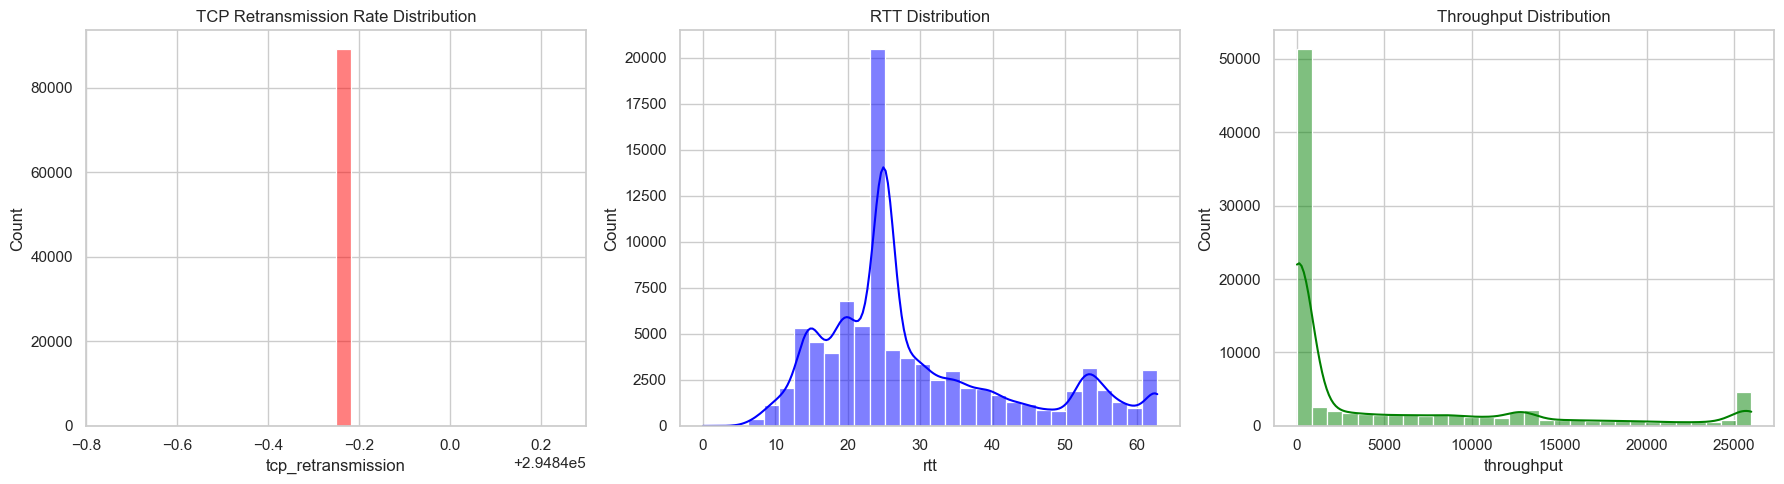

In [81]:

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(agg_df['tcp_retransmission'], bins=30, kde=True, ax=axes[0], color='red')
axes[0].set_title('TCP Retransmission Rate Distribution')

sns.histplot(agg_df['rtt'], bins=30, kde=True, ax=axes[1], color='blue')
axes[1].set_title('RTT Distribution')

sns.histplot(agg_df['throughput'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Throughput Distribution')

plt.tight_layout()
plt.show()


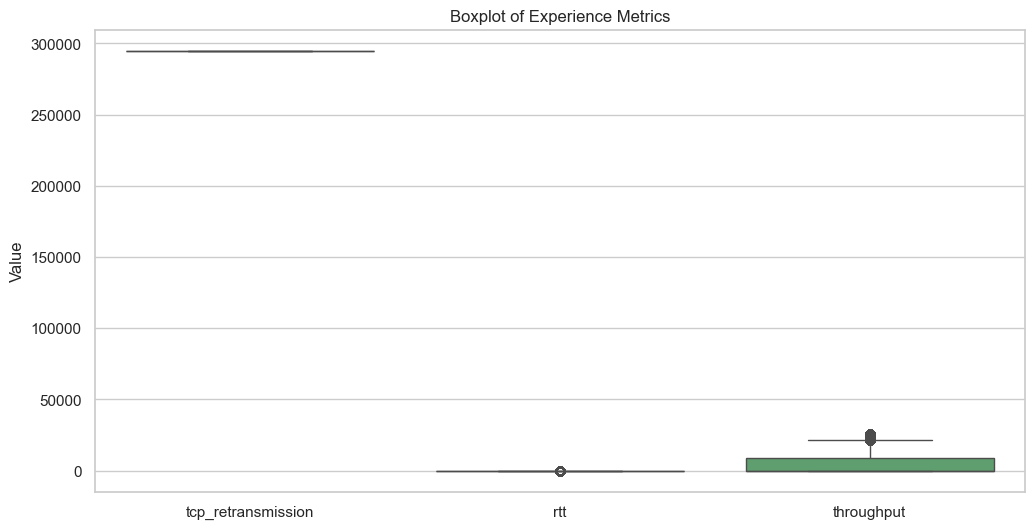

In [83]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=agg_df[['tcp_retransmission', 'rtt', 'throughput']])
plt.title('Boxplot of Experience Metrics')
plt.ylabel('Value')
plt.show()


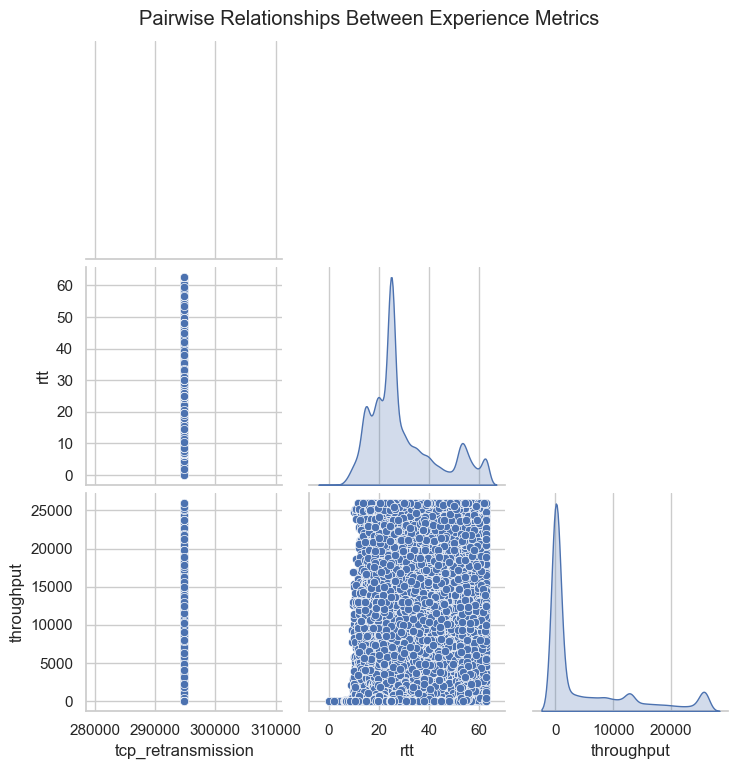

In [85]:
sns.pairplot(agg_df[['tcp_retransmission', 'rtt', 'throughput']], corner=True, diag_kind='kde')
plt.suptitle("Pairwise Relationships Between Experience Metrics", y=1.02)
plt.show()


#  Top/Bottom/Most Frequent Values

In [44]:
agg_df.head()

,msisdn/number,tcp_retransmission,rtt,throughput,handset_type
0,3.360416e+10,294839.75,27.189301,4148.327866,Apple iPhone 6 (A1586)
1,3.360417e+10,294839.75,25.000000,36.000000,Samsung Galaxy S8 (Sm-G950F)
2,3.360417e+10,294839.75,32.250000,11861.500000,Samsung Galaxy S7 (Sm-G930X)
3,3.360418e+10,294839.75,41.500000,33.500000,Apple iPhone 6 (A1549)
4,3.360418e+10,294839.75,35.000000,113.000000,Samsung Galaxy A5 Sm-A520F


In [48]:
# Function to Extract Top, Bottom, and Frequent Values
def summarize_metric(df, column_name):
    print(f"\n===== {column_name.upper()} Statistics =====")

    # Top 10 values
    print("\n Top 10 values:")
    print(df[column_name].sort_values(ascending=False).head(10).reset_index(drop=True))

    # Bottom 10 values
    print("\n Bottom 10 values:")
    print(df[column_name].sort_values(ascending=True).head(10).reset_index(drop=True))

    # Most Frequent 10 values
    print("\n Most Frequent 10 values:")
    print(df[column_name].value_counts().head(10))


In [50]:
# TCP Retransmission
summarize_metric(agg_df, 'tcp_retransmission')

# RTT (Round Trip Time)
summarize_metric(agg_df, 'rtt')

# Throughput
summarize_metric(agg_df, 'throughput')



===== TCP_RETRANSMISSION Statistics =====

 Top 10 values:
0    294839.75
1    294839.75
2    294839.75
3    294839.75
4    294839.75
5    294839.75
6    294839.75
7    294839.75
8    294839.75
9    294839.75
Name: tcp_retransmission, dtype: float64

 Bottom 10 values:
0    294839.75
1    294839.75
2    294839.75
3    294839.75
4    294839.75
5    294839.75
6    294839.75
7    294839.75
8    294839.75
9    294839.75
Name: tcp_retransmission, dtype: float64

 Most Frequent 10 values:
tcp_retransmission
294839.75    89092
Name: count, dtype: int64

===== RTT Statistics =====

 Top 10 values:
0    62.75
1    62.75
2    62.75
3    62.75
4    62.75
5    62.75
6    62.75
7    62.75
8    62.75
9    62.75
Name: rtt, dtype: float64

 Bottom 10 values:
0    0.0
1    0.0
2    1.0
3    2.0
4    2.5
5    3.0
6    4.0
7    4.5
8    4.5
9    5.0
Name: rtt, dtype: float64

 Most Frequent 10 values:
rtt
25.00    16194
14.50     2463
62.75     2222
19.50     2026
20.00     1399
19.00     1380
15.00    

In [87]:
top_tcp = agg_df[['tcp_retransmission']].sort_values(by='tcp_retransmission', ascending=False).head(10)
bottom_tcp = agg_df[['tcp_retransmission']].sort_values(by='tcp_retransmission', ascending=True).head(10)
freq_tcp = agg_df['tcp_retransmission'].value_counts().head(10)


# Experience Metrics by Handset Type
**We will analyze:**

**Average Throughput per Handset Type**

**Average TCP Retransmission per Handset Type**

In [58]:
# Group by handset_type and compute average throughput and tcp retransmission
handset_experience = agg_df.groupby('handset_type').agg({
    'throughput': 'mean',
    'tcp_retransmission': 'mean'
}).reset_index()

C:\Users\gurpr\AppData\Local\Temp\ipykernel_5784\3035302727.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=handset_experience.sort_values('throughput', ascending=False),


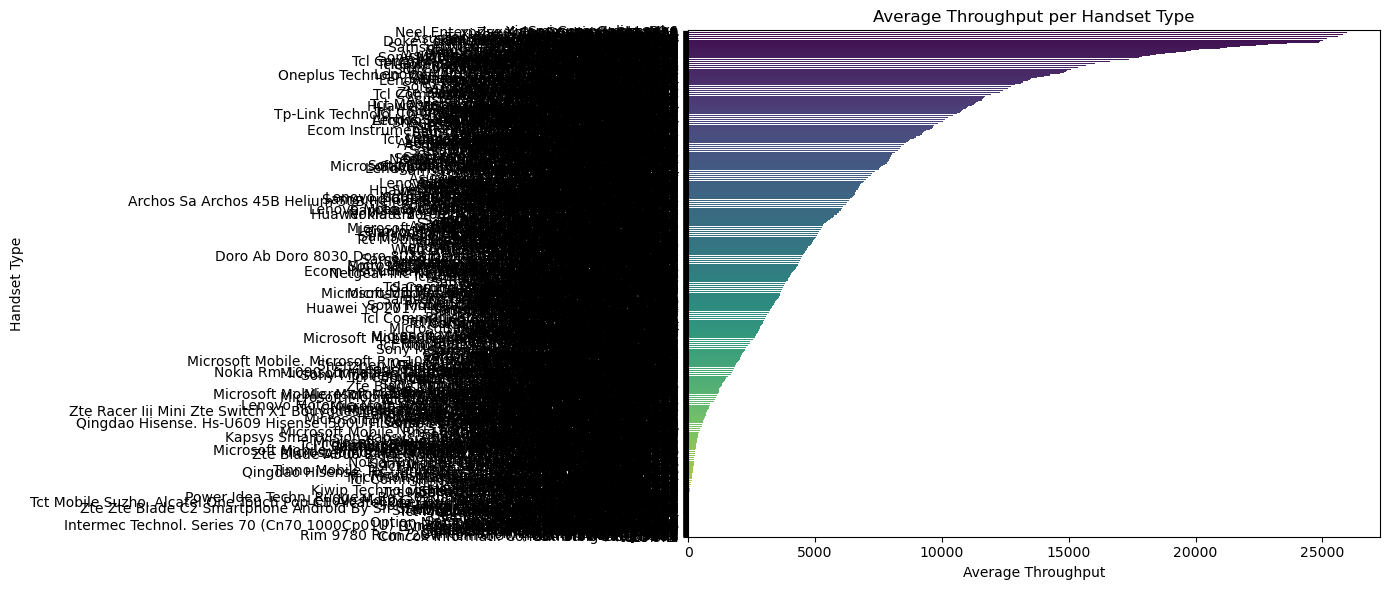

In [60]:
#  Visualize Average Throughput per Handset Type

plt.figure(figsize=(14, 6))
sns.barplot(data=handset_experience.sort_values('throughput', ascending=False),
            x='throughput', y='handset_type', palette='viridis')
plt.title('Average Throughput per Handset Type')
plt.xlabel('Average Throughput')
plt.ylabel('Handset Type')
plt.tight_layout()
plt.show()

C:\Users\gurpr\AppData\Local\Temp\ipykernel_5784\4043262860.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=handset_experience.sort_values('tcp_retransmission', ascending=False),


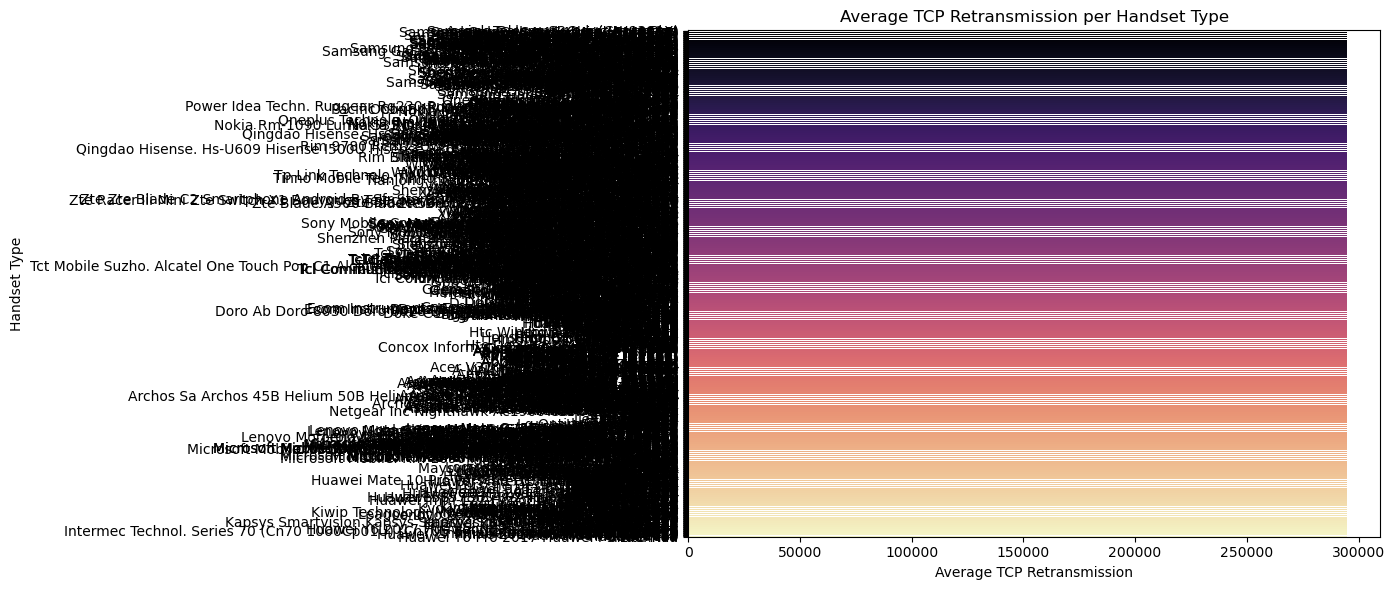

In [62]:
# Visualize Average TCP Retransmission per Handset Type

plt.figure(figsize=(14, 6))
sns.barplot(data=handset_experience.sort_values('tcp_retransmission', ascending=False),
            x='tcp_retransmission', y='handset_type', palette='magma')
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Average TCP Retransmission')
plt.ylabel('Handset Type')
plt.tight_layout()
plt.show()

# K-Means Clustering on Experience Metrics
**We'll segment users into 3 clusters based on:**

**tcp_retransmission**

**rtt**

**throughput**

In [70]:
#  experience features
experience_features = agg_df[['tcp_retransmission', 'rtt', 'throughput']]

# Normalize
scaler = MinMaxScaler()
normalized_exp = scaler.fit_transform(experience_features)

In [72]:

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(normalized_exp)

# cluster labels to original dataframe
agg_df['experience_cluster'] = clusters

# Analyze Cluster Summary Stats

In [75]:
# Summary statistics
cluster_summary = agg_df.groupby('experience_cluster')[['tcp_retransmission', 'rtt', 'throughput']].agg(['mean', 'min', 'max'])
print(cluster_summary)

                   tcp_retransmission                              rtt         \
                                 mean        min        max       mean    min   
experience_cluster                                                              
0                           294839.75  294839.75  294839.75  22.319787   0.00   
1                           294839.75  294839.75  294839.75  35.462584   9.50   
2                           294839.75  294839.75  294839.75  51.274075  32.25   

                             throughput                       
                      max          mean      min         max  
experience_cluster                                            
0                   38.50   1015.493822     0.00  12018.5000  
1                   62.75  19065.173735  9672.75  25970.0000  
2                   62.75   4384.427656     0.00  15235.0625  


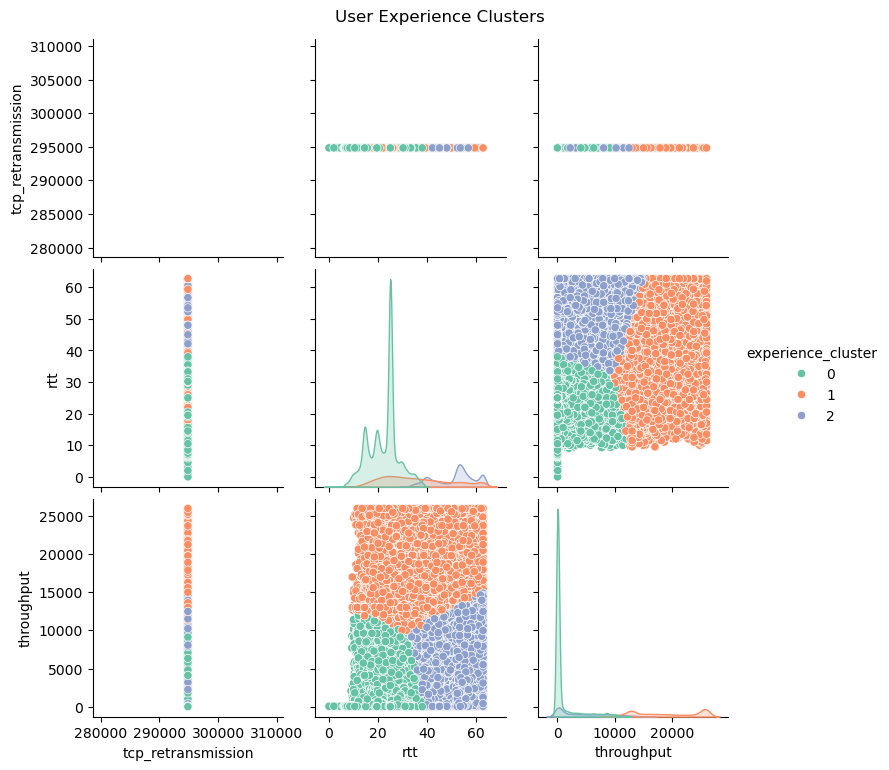

In [77]:

plot_df = agg_df[['tcp_retransmission', 'rtt', 'throughput', 'experience_cluster']].copy()
plot_df['experience_cluster'] = plot_df['experience_cluster'].astype(str)

# Pairplot
sns.pairplot(plot_df, hue='experience_cluster', palette='Set2')
plt.suptitle('User Experience Clusters', y=1.02)
plt.show()

In [79]:
df.to_csv('dataset/Experience_Analytics.csv')